In [13]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import timedelta
from sklearn.metrics import root_mean_squared_error
import pickle
from prepare_data import PrepareData
from pmdarima.arima import auto_arima


Get Data

In [14]:
df = PrepareData.df
train_data = PrepareData.train_data()
test_data = PrepareData.test_data()

In [15]:
#TODO: change this if necessary
attr = "api_temp"

# Training sarima to predict the temperature 

## EDA

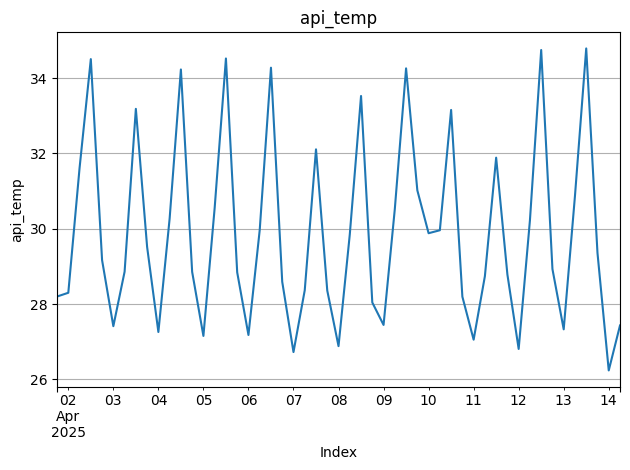

In [25]:
plt.figure()  # Create a new figure for each plot
df['api_temp'].plot()
plt.title('api_temp')
plt.xlabel("Index")  # or "Date" if it's time series
plt.ylabel('api_temp')
plt.grid(True)
plt.tight_layout()
plt.show()

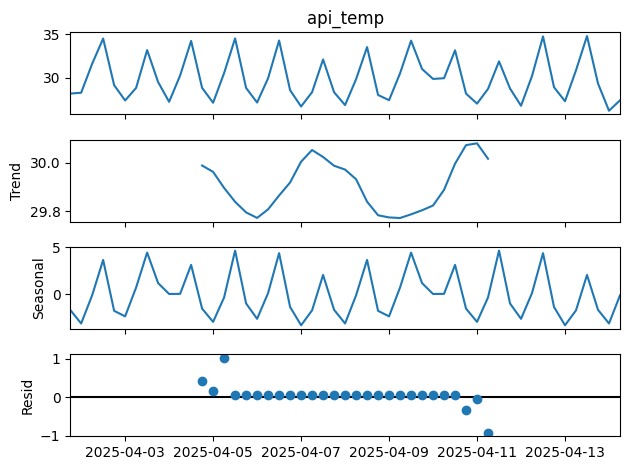

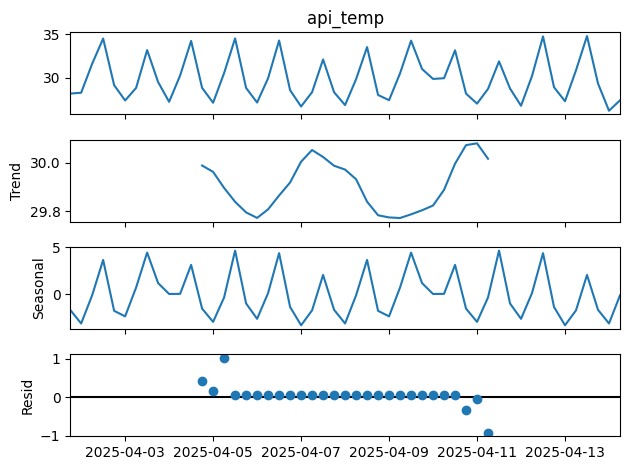

In [16]:
seasonal_decompose(df[attr].interpolate(), model="additive").plot()

In [17]:
diffed_data = df[attr].dropna()
diff = 0
while True:
    result = adfuller(diffed_data)
    if result[1] < 0.05 or result[0] < result[4]["5%"]:
        print(f"d={diff}")
        print('ADF Statistic:', result[0])
        print('p-value:', result[1])
        for key, value in result[4].items():
            print('Critial Values:')
            print(f'   {key}, {value}')
        break
    diffed_data = diffed_data.diff().dropna()
    diff+=1

d=0
ADF Statistic: -3.9353736032188373
p-value: 0.0017894024558539653
Critial Values:
   1%, -3.596635636000432
Critial Values:
   5%, -2.933297331821618
Critial Values:
   10%, -2.6049909750566895


Use d=0.

### Find the P parameter

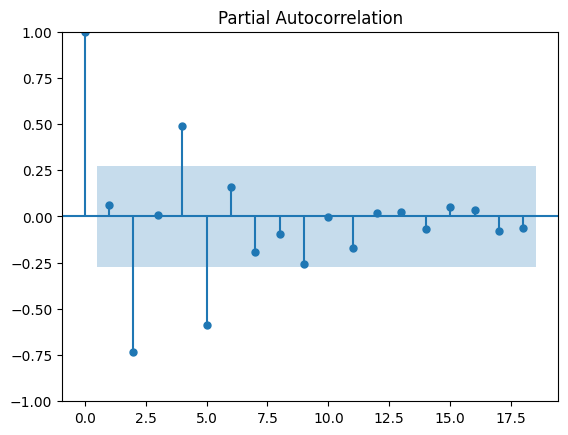

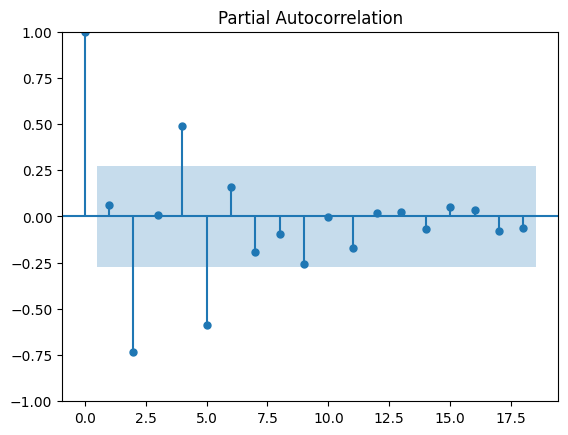

In [18]:
plot_pacf(diffed_data)

Use p = 4

### Find the Q parameter

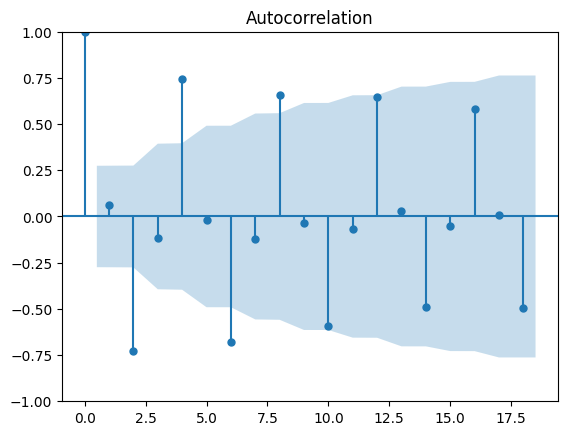

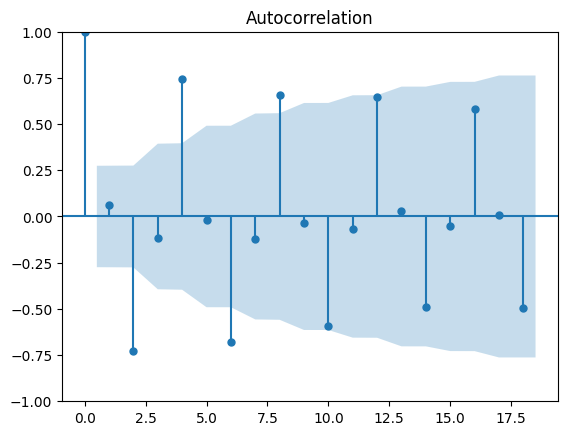

In [19]:
plot_acf(diffed_data)

Use q = 5

## Pre-Processing

The missing value is already filled using KNN Imputer

## Train the model

In [20]:
# Use auto_arima to find the best model parameters
# idk wtf each parameters does, go fix yourself.
#TODO: change parameters
model = auto_arima(
    train_data[attr],
    seasonal=True,
    m=3,  # Seasonality every day
    d=0, #
    D=0,
    max_p=5,
    max_q=5,
    max_P=5,
    max_Q=5,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
)

c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[3] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[3] intercept   : AIC=139.135, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[3] intercept   : AIC=143.070, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[3] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[3]             : AIC=281.521, Time=0.01 sec


c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.wa

 ARIMA(0,0,0)(1,0,0)[3] intercept   : AIC=140.919, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[3] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[3] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[3] intercept   : AIC=141.131, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[3] intercept   : AIC=140.039, Time=0.01 sec


c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.wa

 ARIMA(1,0,1)(0,0,0)[3] intercept   : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[3] intercept
Total fit time: 0.791 seconds


In [40]:
model_attr = SARIMAX(
    endog=train_data[attr], order=(0, 1, 0), seasonal_order=(4, 0,1, 3)
)
attr_results = model_attr.fit()

steps = len(test_data)

attr_prediction = attr_results.get_forecast(
    steps=steps
).predicted_mean
forecast_index = pd.date_range(
    start=test_data.index[0],
    freq=timedelta(days=1),
    periods=int(test_data[attr].count()),
)
attr_prediction.index = test_data.index[:steps]
attr_prediction.columns = ["predicted"]

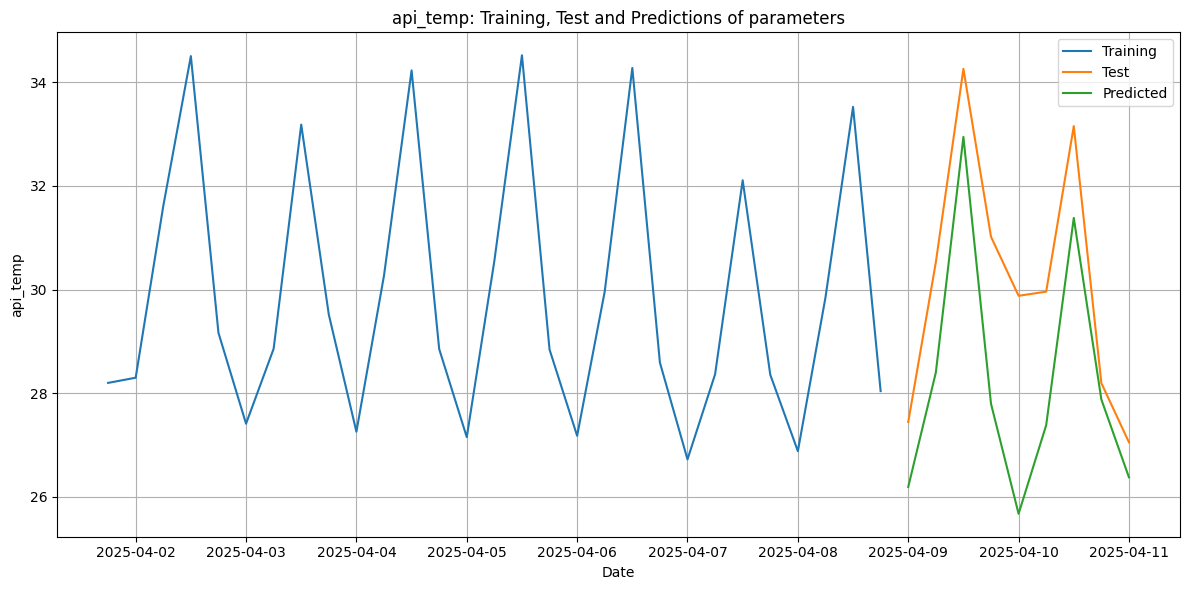

RMSE is :  2.2661416749406933


In [41]:
plt.figure(figsize=(12, 6))
# Ensure datetime index and proper plotting
plt.plot(train_data.index, train_data[attr], label="Training")
plt.plot(test_data.index, test_data[attr], label="Test")
plt.plot(test_data.index, attr_prediction, label="Predicted")

plt.legend()
plt.xlabel("Date")
plt.ylabel(attr)
plt.title(f"{attr}: Training, Test and Predictions of parameters")
plt.grid(True)
plt.tight_layout()
plt.show()

print("RMSE is : ", root_mean_squared_error(test_data[attr], attr_prediction))

## Save the model using pickle

In [ ]:
#TODO: change file name
with open(f"../exports/{attr}_sarima.pkl", "wb") as file:
    pickle.dump(attr_results, file)